# 第7回のコード

資料はMATLABコードだが、ここではJuliaでの実装をする。

なおこのコードの実行の前に以下のパッケージをインストールする必要がある。

```
using Pkg
Pkg.add("IJulia")
Pkg.add("Plots")
Pkg.add("DifferentialEquations")
Pkg.add("FFTW")

```

### 遅延Duffing方程式

$$
\frac{d^{2} x}{d t^{2}}(t)=\gamma \frac{d x}{d t}(t)+\alpha x(t)+\beta x(t-\tau)+\epsilon x(t)^{3}
$$

$$
\begin{cases}
\dot{x} = y\\
\dot{y} = \gamma y + \alpha x+\beta x(t-\tau)+\epsilon x^{3}
\end{cases}
$$

In [1]:
using DifferentialEquations

function d_duffing(du, u, h, p, t)
  α, β, γ, ϵ, τ = p
  hist = h(p, t-τ)[1]; x = u[1]; y = u[2];
  du[1] = y
  du[2] = γ * y + α * x + β * hist + ϵ * x^3
end

h(p, t) = [0.4; 0]

τ = 2.5
lags = [τ]

1-element Vector{Float64}:
 2.5

In [2]:
α = -0.1; β = -5.0; γ = -2.0; ϵ = -10.0
p = (α, β, γ, ϵ, τ)
tspan = (0.0, 50.0)
u0 = [0.4, 0.0]

prob = DDEProblem(d_duffing, u0, h, tspan, p; constant_lags=lags)

DDEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 50.0)
u0: 2-element Vector{Float64}:
 0.4
 0.0

In [3]:
alg = MethodOfSteps(Tsit5())
sol = solve(prob, alg, reltol=1e-8, abstol=1e-8);

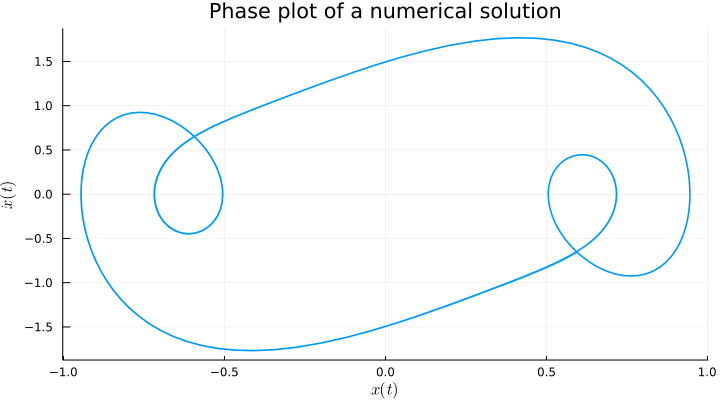

In [4]:
using Plots
ind = floor(Int, length(sol)/2)
plot(sol[1,ind:end], sol[2,ind:end],
    xlabel = "\$x(t)\$",                             # X軸のラベル
    ylabel = "\$\\dot{x}\\,(t)\$",                   # Y軸のラベル
    line   = 1.6,                                    # 線幅
    title  = "Phase plot of a numerical solution",   # タイトル
    size   = (720,400),                              # プロットのサイズ
    legend = false,                                  # 凡例は今回は消す
)

In [5]:
# approximate a period of solution
a = 30
app_period = 6
timestep = 0.1

f_tmp = sol(a+app_period/2:timestep:a+3*app_period/2)
find_period = abs.(f_tmp .- sol(a))
(~,ind) = findmin(find_period[1,:])
b = a+app_period/2 + timestep*(ind-1)
# sol(a+app_period/2:timestep:a+3*app_period/2)[1,:]# x

36.3

In [6]:
using FFTW
function ddefouriercoeffs(f, I, N, n)
    a = I[1]; b = I[2];
    # x_j: equidistance node points
    h = (b-a)/(2.0*N+1)
    j = 0:2*N
    xⱼ = a .+ j*h
    # f_j: function values on node points
    fⱼ = f(xⱼ)[n,:]
    return (fftshift(fft(fⱼ)))/(2*N+1)
end

ddefouriercoeffs (generic function with 1 method)

In [7]:
N = 61
x = ddefouriercoeffs(sol,[a,b],N,1)
# plot(abs.(x),yscale=:log10,)

123-element Vector{ComplexF64}:
 -4.1594266341445245e-5 - 3.8900089385527893e-7im
 -4.1609152637212515e-5 - 1.1675273919625356e-6im
 -4.1639033681520964e-5 - 1.9476011196272933e-6im
  -4.168398739900116e-5 - 2.7301764128109334e-6im
  -4.174438130946156e-5 - 3.5164351521963528e-6im
  -4.182037376210047e-5 - 4.307354406921734e-6im
  -4.191257553850363e-5 - 5.104061315724068e-6im
 -4.2021378423217265e-5 - 5.907641652068994e-6im
 -4.2147416987792814e-5 - 6.719300285250103e-6im
  -4.229149331172714e-5 - 7.540200482443511e-6im
  -4.245429580215044e-5 - 8.371626953257527e-6im
  -4.263697423703051e-5 - 9.214901341039766e-6im
  -4.284044879588514e-5 - 1.0071401973074932e-5im
                        ⋮
 -4.2636974237033125e-5 + 9.214901341028466e-6im
  -4.245429580214774e-5 + 8.371626953239951e-6im
 -4.2291493311729836e-5 + 7.540200482441084e-6im
  -4.214741698779193e-5 + 6.719300285253043e-6im
   -4.20213784231999e-5 + 5.907641652062147e-6im
  -4.191257553849516e-5 + 5.10406131571813e-6im
  -4.1

In [8]:
function plot_solution(u, index)
    # index = 1: profile of solution
    #         2: Fourier mode
    #         3: phase profile
    L = 2π/real(u[1])
    a = u[2:end]
    m = length(u)/2
    m_pad = 1000
    a_pad = [zeros(m_pad);a;zeros(m_pad)]
    N = m-1
    N_pad = m+m_pad-1
    k = -N_pad:N_pad
    dx = L/(2*N_pad-1)
    x = dx*(0:2*N_pad)
    if index == 1
    # Plot profile:
        plot(x,real((2*N_pad+1)*ifft(ifftshift(a_pad))),
            xlabel = "\$t\$",
            ylabel = "\$x\\,(t)\$",
            line   = 1.6,
            title  = "Profile of solution",
            size   = (720,400),
            legend = false,
        )
    elseif index == 2
    # Plot Fourier coefficients:
        plot(-N:N,abs.(a),yscale=:log10,
            xlabel = "\$k\$",
            ylabel = "\$|a_k\\,|\$",
            line   = 1.6,
            title  = "Fourier coefficients of solution",
            size   = (720,400),
            legend = false,
        )
    elseif index == 3
    # Plot phase:
      plot(real((2*N_pad+1)*ifft(ifftshift(a_pad))),real((2*N_pad+1)*ifft(ifftshift(a_pad.*(im*k)))),
            xlabel = "\$x(t)\$",
            ylabel = "\$\\dot{x}\\,(t)\$",
            line   = 1.6,
            title  = "Phase plot of a numerical solution",
            size   = (720,400),
            legend = false,
        )
    end
end
function plot_solution!(u)
    L = 2π/real(u[1])
    a = u[2:end]
    m = length(u)/2
    m_pad = 1000
    a_pad = [zeros(m_pad);a;zeros(m_pad)]
    N = m-1
    N_pad = m+m_pad-1
    k = -N_pad:N_pad
    dx = L/(2*N_pad-1)
    x = dx*(0:2*N_pad)
    plot!(real((2*N_pad+1)*ifft(ifftshift(a_pad))),real((2*N_pad+1)*ifft(ifftshift(a_pad.*(im*k)))),line=1.6,)
end

plot_solution! (generic function with 1 method)

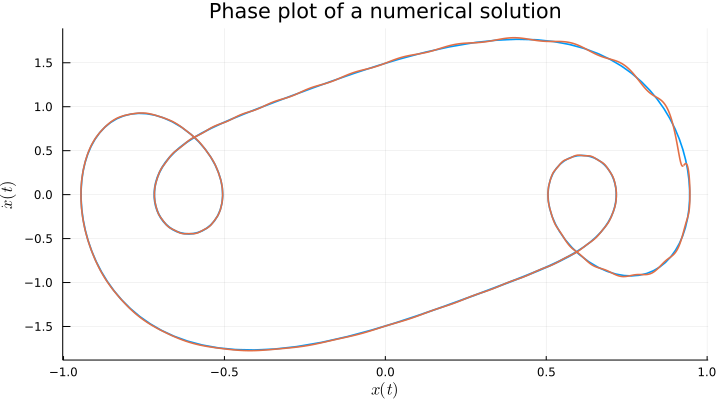

In [9]:
x0 = [2*pi/(b-a);x]
plot_solution!(x0)

In [10]:
function convp(a,p)
    M  = Int((length(a) + 1)/2)
    n  = (p-1)*M
    ta = [zeros(n); a; zeros(n)]
    tb = ifft(ifftshift(ta))
    tc = fftshift(fft(tb.^p))*(2*p*M-1)^(p-1)
    return tc[n+1:end-n], tc[p:end-p+1]
end

function F_fourier(x, p, η₀)
    (α, β, γ, ϵ, τ) = p
    N = (length(x)-2)/2
    ω = x[1]
    a = x[2:end]
    (a³,~) = convp(a,3)
    eta = sum(a) - η₀

    k = -N:N
    f = (k.^2 * ω^2 + im * γ * k * ω .+ α + β * exp.(-im*k*ω*τ)).*a + ϵ*a³

    return [eta;f]
end

function DF_fourier(x, p)
    (α, β, γ, ϵ, τ) = p
    N = Int((length(x)-2)/2)
    ω = x[1]
    a = x[2:end]
    k = -N:N

    DF = zeros(ComplexF64,2*N+2,2*N+2)

    DF[1,2:end] .= 1
    DF[2:end,1] = (2*ω*k.^2 + im*γ*k - im*k*τ*β.*exp.(-im*k*ω*τ)).*a

    (~,a2) = convp(a,2)
    
    M = zeros(ComplexF64,2*N+1, 2*N+1)

    for j=-N:N
        M[k.+(N+1), j+N+1] = 3.0*ϵ*a2[k.-j.+(2*N+1)]
    end
    
    L = diagm(k.^2*ω^2 + im*γ*k*ω .+ α + β*exp.(-im*k*ω*τ))
    
    DF[2:end,2:end] = L + M
    return DF
end

DF_fourier (generic function with 1 method)

Before step #1, ||F||_1 = 8.013785059533912
After step #1, ||F||_1 = 0.0684960778536524
After step #2, ||F||_1 = 0.0003846433790842428
After step #3, ||F||_1 = 6.299894887948891e-8
After step #4, ||F||_1 = 1.5987525042404632e-14


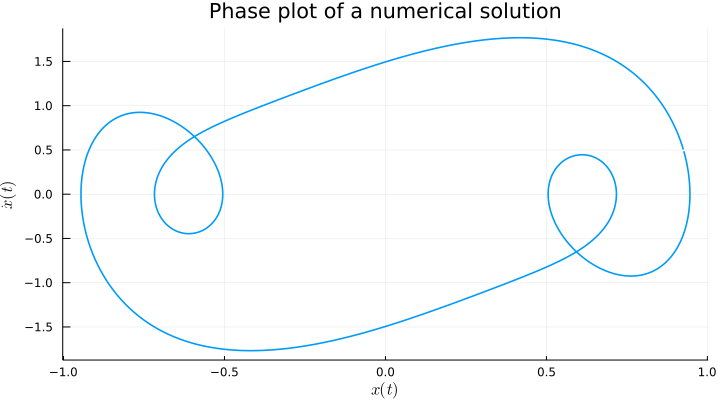

In [11]:
using LinearAlgebra
# Initial value of Newton method
η₀ = real(sum(x0[2:end]))
x = x0

# Newton iteration
tol = 5e-10
F = F_fourier(x, p, η₀)
println("Before step #1, ||F||_1 = $(norm(F,1))")
num_itr = 0

while num_itr ≤ 100
    x = x - DF_fourier(x, p)\F
    num_itr += 1
    F = F_fourier(x, p, η₀)
    println("After step #$(num_itr), ||F||_1 = $(norm(F,1))")
    if norm(F,1) < tol
        break
    end
end

L = 2π/real(x[1])
plot_solution(x, 3)

In [60]:
using Zygote
function F_fourier_real(x_complex, p)
#     n = Int(length(x_real)/2)
#     x = x_real[1:n]; y = x_real[n+1:end]
#     x_complex = x + im*y
    F_complex = F_fourier(x_complex, p, η₀)
#     return [real(F_complex);imag(F_complex)]
    return real(F_complex)
end

function reshape_x(x)
    return [real(x);imag(x)]
end

# function real_convp(x_real,p)
#     n = Int(length(x_real)/2)
#     x = x_real[1:n]; y = x_real[n+1:end]
#     x_complex = x + im*y
#     (y,) = convp(x_complex,p)
#     return [real(y);imag(y)]
# end
# real_convp(reshape_x(x[2:end]),3)

(DF_zygote,) = jacobian(x -> F_fourier_real(x,p), x)

(ComplexF64[0.0 + 0.0im 1.0 + 0.0im … 1.0 + 0.0im 1.0 + 0.0im; 1.3815517359807997e-15 - 1.6641535361854915e-14im 3710.0791974098534 - 117.04599631208367im … -9.181317914257412e-17 - 4.313253123021543e-16im 2.468824785217666e-16 + 1.740147409217058e-16im; … ; 2.853444885359766e-16 - 1.1634186460278669e-16im -3.201103540971863e-16 - 4.260476524374143e-16im … 3584.9073810169634 + 123.5707581929049im -3.218807332890764e-17 + 5.454384080293176e-16im; 1.5237491123515828e-15 + 1.6615942759171732e-14im 2.9172251272040865e-16 + 4.738886290793242e-16im … 8.732811581319162e-17 - 2.716490261164352e-16im 3710.0791974098534 + 117.04599631208386im],)

In [62]:
n = length(x)
# DF_1 = (DF_zygote[1:n,1:n] + im*DF_zygote[n+1:end,1:n])
# DF_2 = (-im*DF_zygote[1:n,n+1:end] + DF_zygote[n+1:end,n+1:end])
DF_1 = conj(DF_zygote[1:n,1:n])
DF_1 = conj(DF_zygote)

# plot_solution(x,3)
DF = DF_fourier(x, p)
norm(DF-DF_1,Inf)
# wireframe(abs.(DF-DF_1))
# norm(diag(DF_1))

5.149351787847944e-13

In [59]:
function jacobi(f, x)
  y, back = Zygote.pullback(f, x)
  back(1)[1], back(im)[1]
end

jacobi(x -> 3*x.^2 .+ 2*x .+ 1, 1+2im)

(8 - 12im, 12 + 8im)